['base+arterial+blood_bxvalue_counts', 'base+arterial+blood_counts', 'base+arterial+blood_values', 'base+arterial+blood_values_counts', 'base+arterial_bxvalue_counts', 'base+arterial_counts', 'base+arterial_values', 'base+arterial_values_counts', 'base_counts', 'base_values', 'base_values_counts']
[0.9214975845410628, 0.9085899758454106, 0.8857185990338164, 0.9121376811594204, 0.9213466183574879, 0.9248188405797101, 0.8680555555555556, 0.9132699275362318, 0.9221014492753624, 0.8329559178743962, 0.8922856280193237]
['base+arterial+blood_bxvalue_counts', 'base+arterial+blood_counts', 'base+arterial+blood_values', 'base+arterial+blood_values_counts', 'base+arterial_bxvalue_counts', 'base+arterial_counts', 'base+arterial_values', 'base+arterial_values_counts', 'base_counts', 'base_values', 'base_values_counts']
[0.876207729468599, 0.9087409420289856, 0.813707729468599, 0.8547705314009661, 0.882548309178744, 0.9066274154589371, 0.8067632850241546, 0.8685084541062802, 0.9010416666666666, 0.8

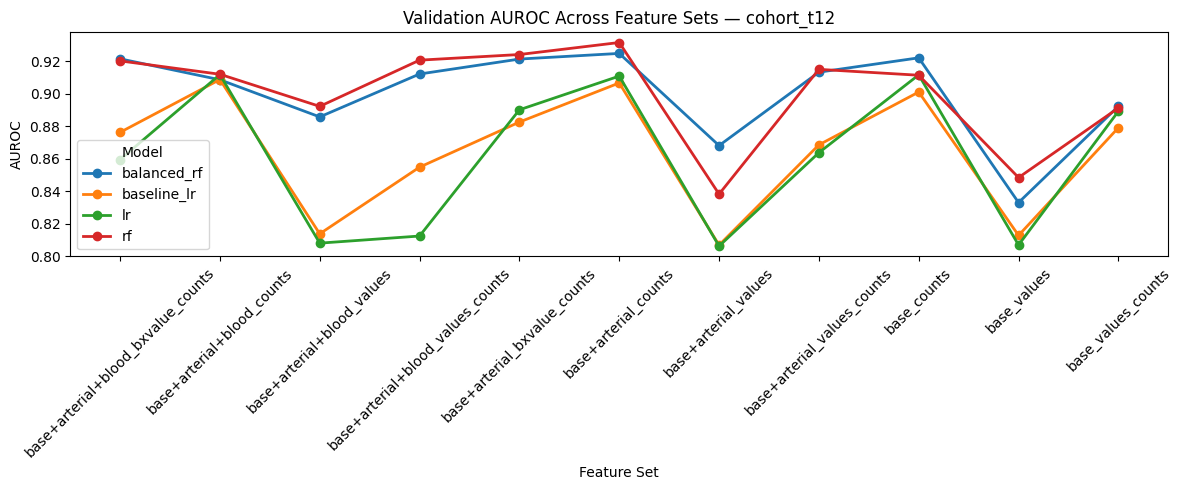

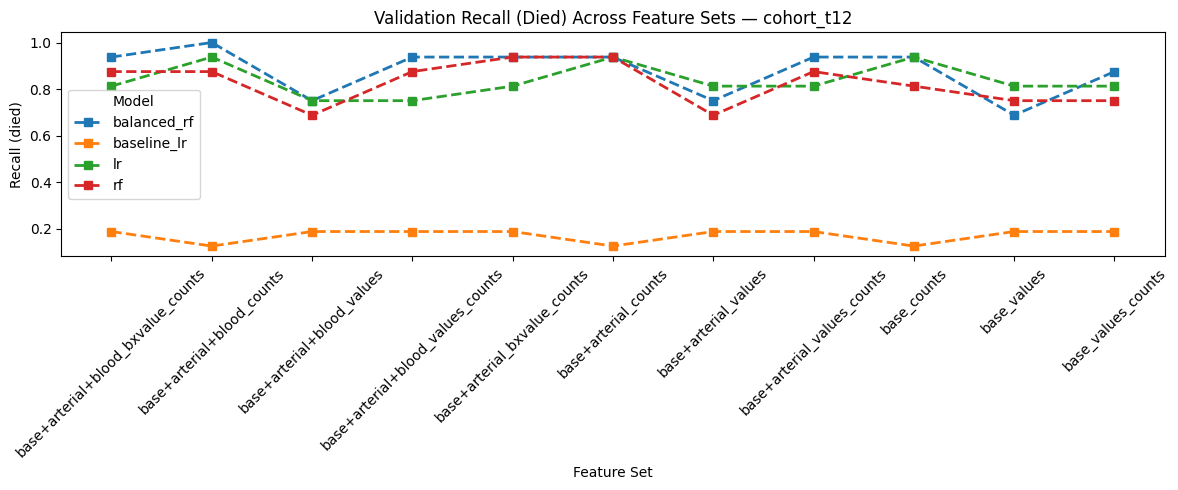

['base+arterial+blood_bxvalue_counts', 'base+arterial+blood_counts', 'base+arterial+blood_values', 'base+arterial+blood_values_counts', 'base+arterial_bxvalue_counts', 'base+arterial_counts', 'base+arterial_values', 'base+arterial_values_counts', 'base_counts', 'base_values', 'base_values_counts']
[0.8511586452762925, 0.8645276292335115, 0.8167706476530006, 0.8404634581105168, 0.8415032679738562, 0.855169340463458, 0.8026589423648247, 0.8367498514557339, 0.826797385620915, 0.7942661913250147, 0.827243018419489]
['base+arterial+blood_bxvalue_counts', 'base+arterial+blood_counts', 'base+arterial+blood_values', 'base+arterial+blood_values_counts', 'base+arterial_bxvalue_counts', 'base+arterial_counts', 'base+arterial_values', 'base+arterial_values_counts', 'base_counts', 'base_values', 'base_values_counts']
[0.85650623885918, 0.8302881758764111, 0.820409982174688, 0.8492275698158052, 0.8553178847296494, 0.8328877005347594, 0.8166963755199049, 0.8361556743909684, 0.8296197266785502, 0.8239

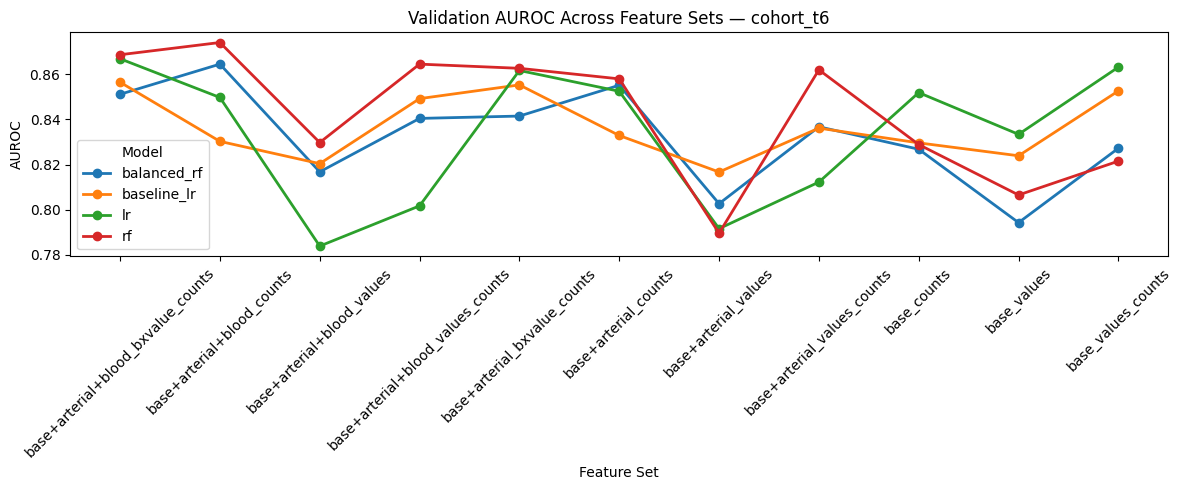

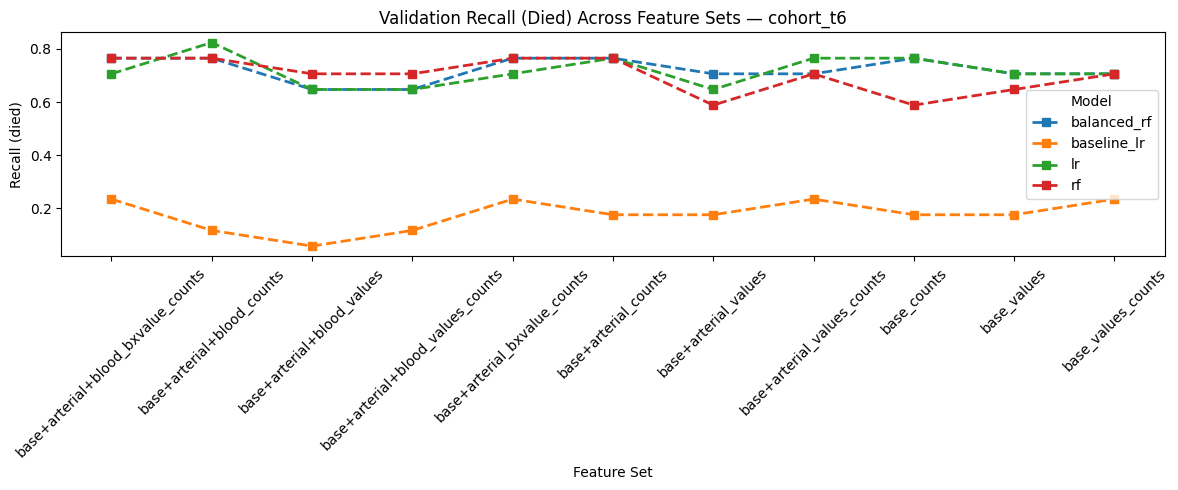

In [3]:
import json
import os
import matplotlib.pyplot as plt

LOG_ROOT = "logs"
COHORTS = ["cohort_t12", "cohort_t6"]
MODELS_TO_PLOT = ["baseline_lr", "lr", "rf", "balanced_rf"]

def load_all_models(feature_path):
    """Return dict: model_name -> (auroc, recall_died)."""
    results = {}
    for file in os.listdir(feature_path):
        if not file.endswith(".json"):
            continue
        model_name = file.replace(".json", "")
        json_path = os.path.join(feature_path, file)

        with open(json_path, "r") as f:
            j = json.load(f)

        val = j["validation"]
        results[model_name] = (val["auroc"], val["recall_died"])
    
    return results


def plot_cohort(cohort_name):
    cohort_dir = os.path.join(LOG_ROOT, cohort_name)
    feature_sets = sorted([
        fs for fs in os.listdir(cohort_dir)
        if os.path.isdir(os.path.join(cohort_dir, fs)) 
        and not fs.startswith(".")
    ])

    # Collect metrics: model -> feature_set -> metric
    auroc_by_model = {}
    recall_by_model = {}

    for fs in feature_sets:
        fs_path = os.path.join(cohort_dir, fs)
        if not os.path.isdir(fs_path):
            continue

        model_results = load_all_models(fs_path)

        for model_name, (au, rc) in model_results.items():
            if model_name not in MODELS_TO_PLOT:
                continue
            auroc_by_model.setdefault(model_name, []).append(au)
            recall_by_model.setdefault(model_name, []).append(rc)

    # ---- Plot AUROC ----
    plt.figure(figsize=(12, 5))
    plt.title(f"Validation AUROC Across Feature Sets — {cohort_name}")
    for model_name, values in auroc_by_model.items():
        print(feature_sets)
        print(values)
        plt.plot(feature_sets, values, marker="o", linewidth=2, label=model_name)
    plt.ylabel("AUROC")
    plt.xlabel("Feature Set")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

    # ---- Plot Recall (died) ----
    plt.figure(figsize=(12, 5))
    plt.title(f"Validation Recall (Died) Across Feature Sets — {cohort_name}")
    for model_name, values in recall_by_model.items():
        plt.plot(feature_sets, values, marker="s", linestyle="--", linewidth=2, label=model_name)
    plt.ylabel("Recall (died)")
    plt.xlabel("Feature Set")
    plt.xticks(rotation=45)
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()


# Run for all cohorts
for cohort in COHORTS:
    plot_cohort(cohort)
